# PyTorch

Es un framwork basado en la libreria Torch del lenguaje (Lua), dicho framework esta desarrollado en **Python** y **C++**, implementado muchas funcionalidades para **Machine Learning** entre ellas:

1. Tensores.
2. Autograd.
3. Módulos de redes neuronales.
4. Herramientas de entrenamiento, datasets, optimizadores, etc

## PyTorch Geometric Temporal
Es una extensión de PyTorch Geometric que a su vez es una libreria de PyTorch lo cual nos permite trabajar con **grafos temporales**, grafos donde su estrcutura cambia con el tiempo.

### Ejemplo:

A continuación se hará un ejemplo de este framework, el dataset a usar es **Chickenpox** datos respecto a la viruela húngara, el **objetivo** predecir cuantos casos se reportarana la siguiente semana en cada condado.

1. **Nodos** Condados.
2. **Aristas** Conexión entre los condados.
3. **Features** El número de casos reportados por semana en cada condado.
4.  **Tiempo** Semanas

In [1]:
!pip install torch-geometric-temporal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Para esto cargaremos el dataset Chickenpox
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split # importamos para dividir el dataset

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

# Dividimos el dataset una parte para entrenar y otra para probar
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

En este bloque código definimos la red neuronal que irá entrenando para este caso una **DCRNN**

In [3]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

# Creamos la red neuronal DCRNN
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        # caracteristicas de cada nodo, tamañ interno, pasos a mirar atrás
        self.recurrent = DCRNN(node_features, 32, 1)

        #capa lineal
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

Ahora en esta sección de código es donde se realizar el entrenamiento de la red neuronal definida anteriormente.

In [4]:
from tqdm import tqdm

model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat.squeeze() - snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [00:47<00:00,  4.20it/s]


Realizamos la prueba final del modelo, mide que tan bien predice sobre datos que nunca vio en el entrenamiento

In [5]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat.squeeze() - snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.7419


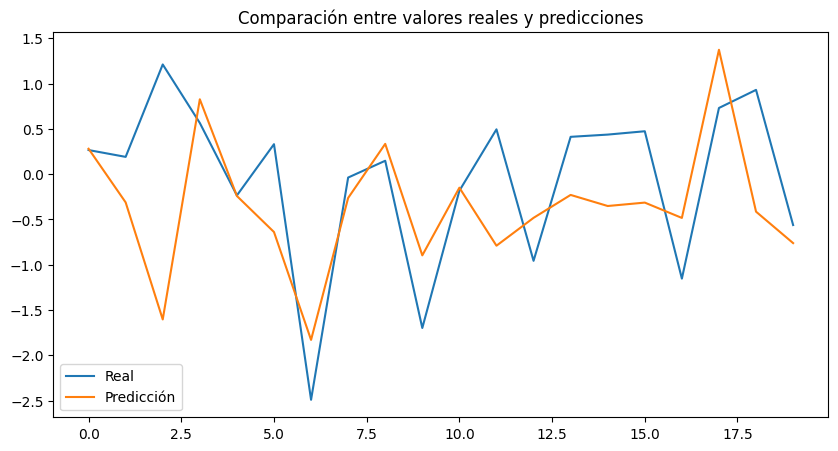

In [6]:
import matplotlib.pyplot as plt

# Tomemos el primer snapshot del test
snapshot = test_dataset[0]

# Predicciones del modelo
y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).squeeze().detach()

# Valores reales
y_real = snapshot.y

plt.figure(figsize=(10,5))
plt.plot(y_real.numpy(), label="Real")
plt.plot(y_hat.numpy(), label="Predicción")
plt.legend()
plt.title("Comparación entre valores reales y predicciones")
plt.show()
